MEG Signal Modeling using Recurrent Neural Networks
---------------------------------------------------

This notebook reads ICANN 2011 MEG Mind Reading competition data set and creates an LSTM based model for predicting MEG activity for 10Hz, 20Hz and 35Hz channels.

Please refer to https://nextonsblog.wordpress.com/?p=1912 for more information.

In [1]:
import numpy as np
import scipy.io

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Global configuration.
FILENAME = "../data/megicann_train_v2.mat"
DATASET = 'train_day1'
FREQ_DOMAINS = [3, 4, 5]
VALIDATION_SAMPLES = 0.2
N_EPOCHS = 50
N_HISTORY_SAMPLES = 10
BATCH_SIZE = 1000

# Ensure that the results can be repeated
np.random.seed(42)

In [3]:
# Original data is in format train[frequency][sample, channel, time].
# make different frequencies appear as channels and swap channel and time.
def preprocess(raw_data):
    # Move different frequencies to channels
    samples = raw_data[0, FREQ_DOMAINS[0]][:]
    for freq_domain in FREQ_DOMAINS[1:]:
        samples = np.concatenate([samples, raw_data[0, freq_domain][:]], axis=1)
        
    # Normalize the data within each sample (per channel) and ensure that type is ok
    for i, sample in enumerate(samples):
        sample_mean = sample.mean(axis=1);
        sample_std = sample.std(axis=1);
        samples[i] = ((sample.transpose() - sample_mean) / sample_std).transpose()
        samples[i] = samples[i]
    
    # Transpose the data to [sample, time, channel] format
    samples = np.transpose(samples, axes=(0, 2, 1))
    
    return samples

In [4]:
# Load samples and preprocess them
train_dict = scipy.io.loadmat(FILENAME)
train_dataset = preprocess(train_dict[DATASET])
train_dict = None

# Split samples into training and validation sets
num_val_samples = int(np.ceil(VALIDATION_SAMPLES * len(train_dataset) - 1))
val_dataset = train_dataset[:num_val_samples]
train_dataset = train_dataset[num_val_samples:]

In [5]:
# Helpers for initializing a graph for visualization
x_points = np.arange(0, train_dataset.shape[1], dtype=float) / train_dataset.shape[1]
def init_fig():
    plt.figure(figsize=(20,5))
    plt.ylabel("Amplitude")
    plt.xlabel("Time")
    plt.ticklabel_format(style='plain', axis='x', scilimits=(0,1000))

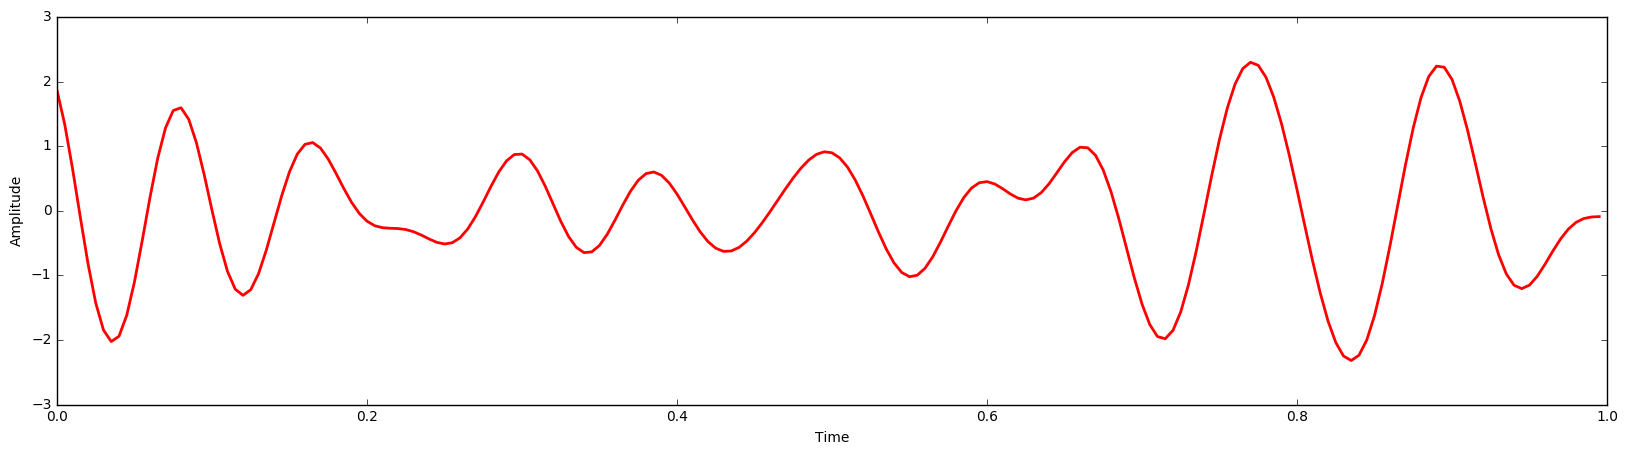

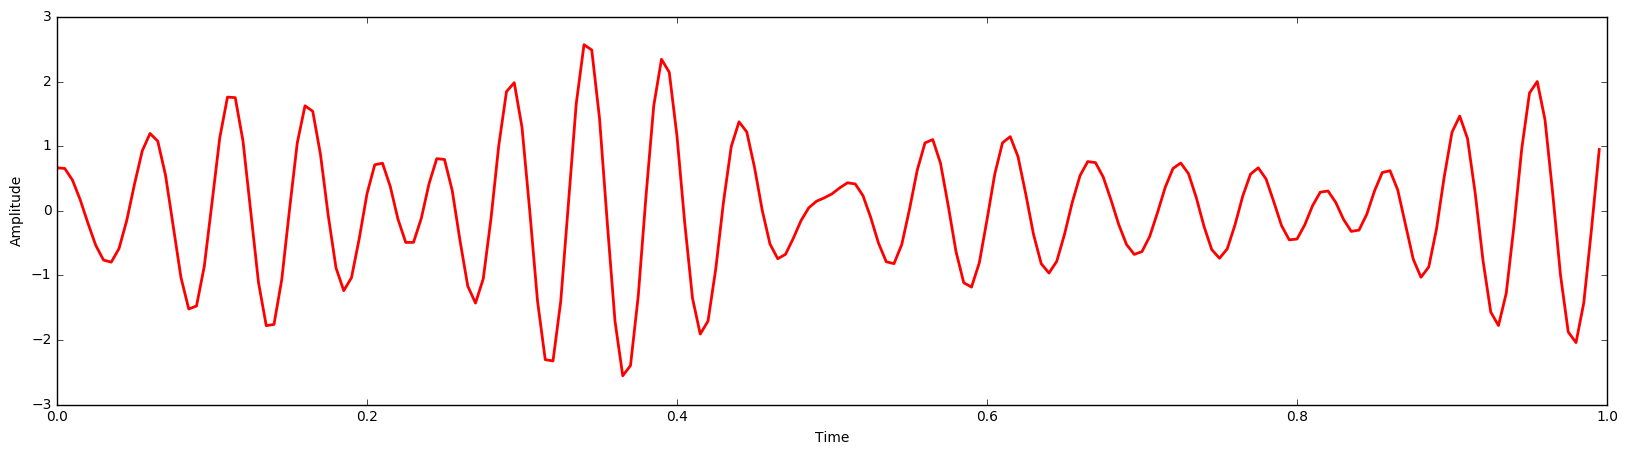

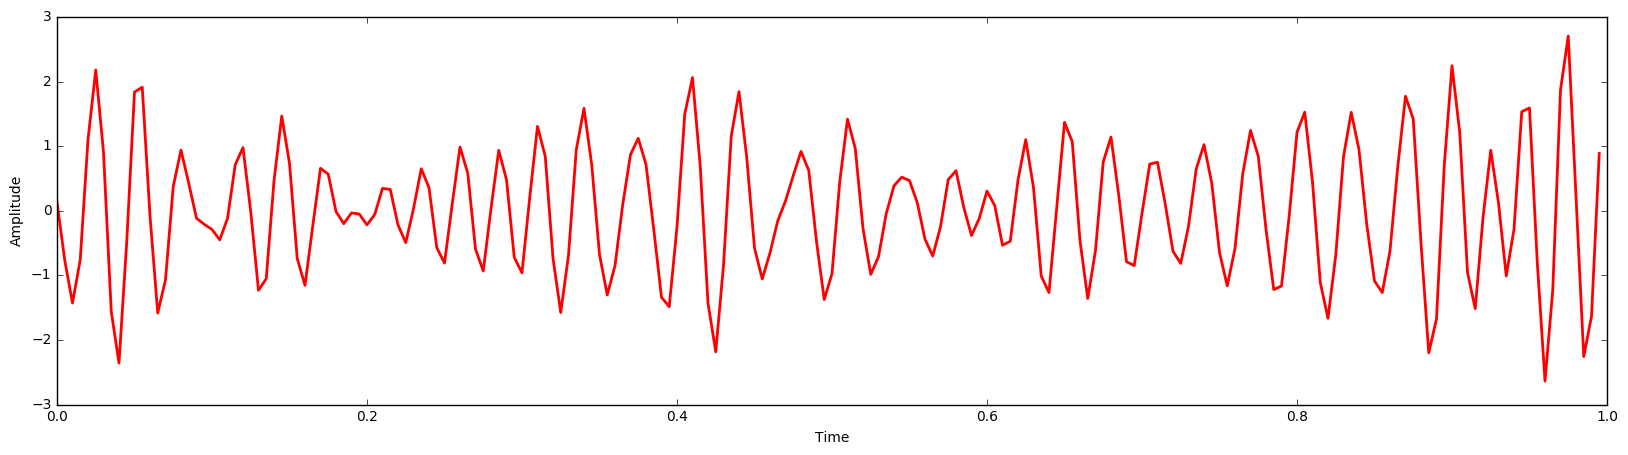

In [6]:
# Visualize some of the channels
init_fig(); plt.plot(x_points, train_dataset[0,:,0].transpose(), linewidth=2, color='red');
init_fig(); plt.plot(x_points, train_dataset[0,:,204].transpose(), linewidth=2, color='red');
init_fig(); plt.plot(x_points, train_dataset[0,:,408].transpose(), linewidth=2, color='red');

In [7]:
# Convert the sequences into x-y pairs
def convert(samples, n_history_samples):
    samples_x = []
    samples_y = []

    # We may have multiple samples - each of which is a bundle of time series
    for sample in samples:
        # Construct x-y pairs for each time step
        for i in range(len(sample) - n_history_samples - 1):
            x = sample[i:(i + n_history_samples), :]
            samples_x.append(x)
            samples_y.append(sample[i + n_history_samples, :])
    
    return np.array(samples_x), np.array(samples_y)

# Prepare training and validation data sets
train_x, train_y = convert(train_dataset, N_HISTORY_SAMPLES)
val_x, val_y = convert(val_dataset, N_HISTORY_SAMPLES)

In [8]:
# Build the network
model = Sequential()
model.add(LSTM(train_x.shape[2] * 3, input_shape=(N_HISTORY_SAMPLES, train_x.shape[2])))
model.add(Dense(train_x.shape[2] * 2))
model.add(Dense(train_x.shape[2]))
model.compile(loss='mean_squared_error', optimizer='adam')

In [9]:
# Finally, train the network
model.fit(train_x, train_y, epochs=N_EPOCHS, batch_size=BATCH_SIZE, verbose=1, validation_data=(val_x, val_y))

Train on 102438 samples, validate on 25515 samples
Epoch 1/50
102438/102438 [==============================] - 111s - loss: 0.2551 - val_loss: 0.0560
Epoch 2/50
102438/102438 [==============================] - 49s - loss: 0.0347 - val_loss: 0.0256
Epoch 3/50
102438/102438 [==============================] - 38s - loss: 0.0206 - val_loss: 0.0189
Epoch 4/50
102438/102438 [==============================] - 38s - loss: 0.0157 - val_loss: 0.0151
Epoch 5/50
102438/102438 [==============================] - 38s - loss: 0.0130 - val_loss: 0.0132
Epoch 6/50
102438/102438 [==============================] - 38s - loss: 0.0111 - val_loss: 0.0117
Epoch 7/50
102438/102438 [==============================] - 38s - loss: 0.0098 - val_loss: 0.0107
Epoch 8/50
102438/102438 [==============================] - 38s - loss: 0.0089 - val_loss: 0.0100
Epoch 9/50
102438/102438 [==============================] - 38s - loss: 0.0081 - val_loss: 0.0088
Epoch 10/50
102438/102438 [==============================] - 38s -

In [10]:
# Predict samples using the given seed sample
def predict(seed_sample, num_samples):
    n_history_samples = seed_sample.shape[0]
    num_channels = seed_sample.shape[1]
    
    x = np.copy(seed_sample)
    x = np.expand_dims(x, 0)
    y = np.zeros([num_samples - n_history_samples, num_channels])
    
    for i in range(0, num_samples - n_history_samples):
        # Predict a single sample for all channels
        sample = model.predict(x)
        
        # Store the sample
        y[i,:] = sample
        
        # Update the history
        x[:,0:n_history_samples - 1,:] = x[:,1:n_history_samples,:]
        x[0,n_history_samples - 1,:] = sample

    # Concatenate the existing history with predictions
    y = np.concatenate([seed_sample, y])

    return y

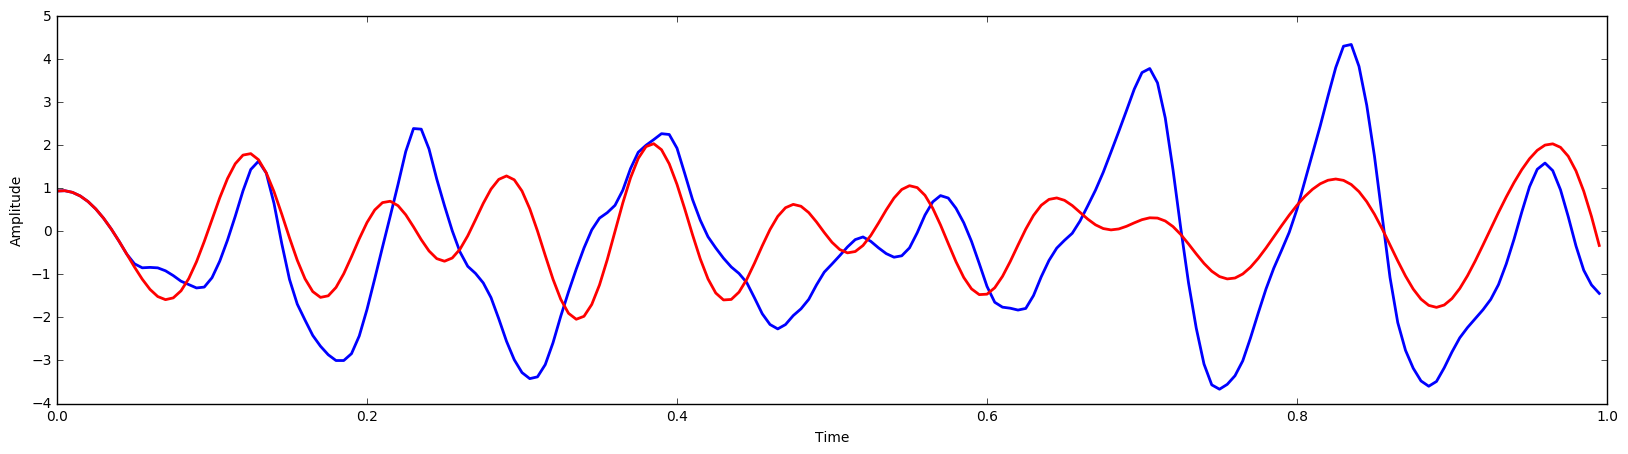

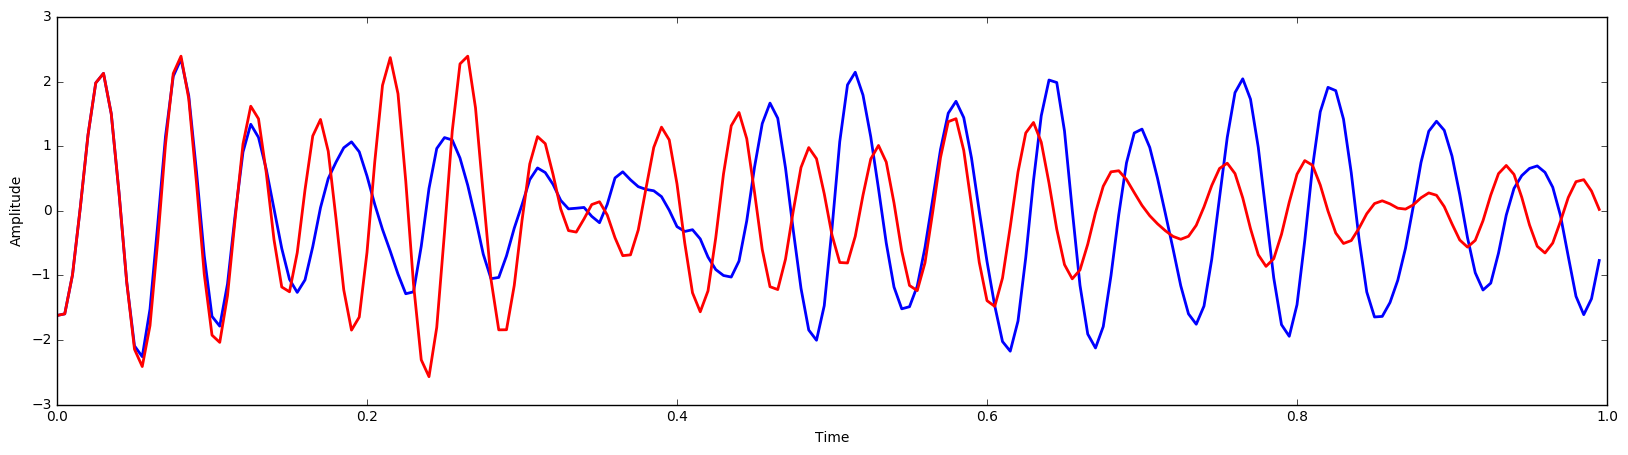

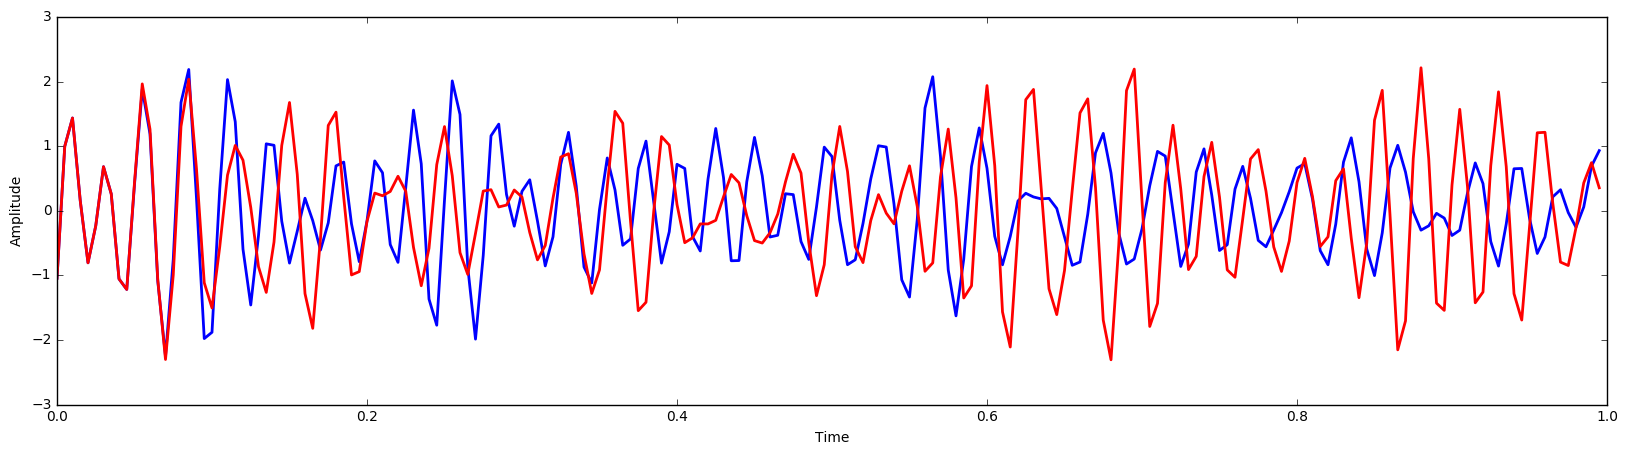

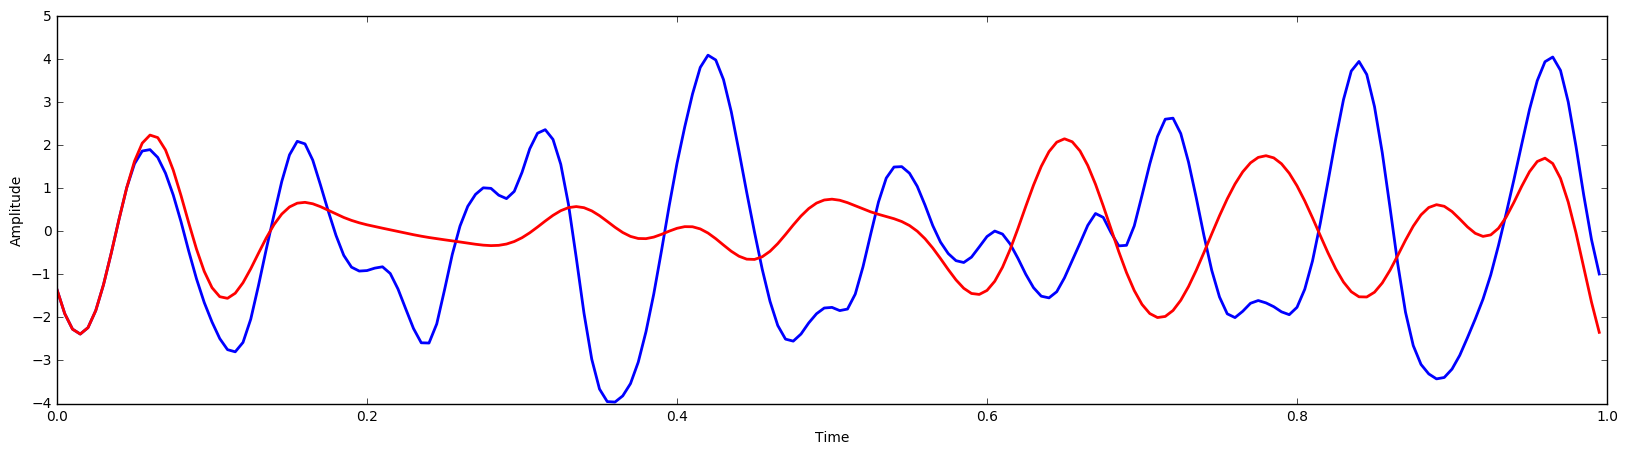

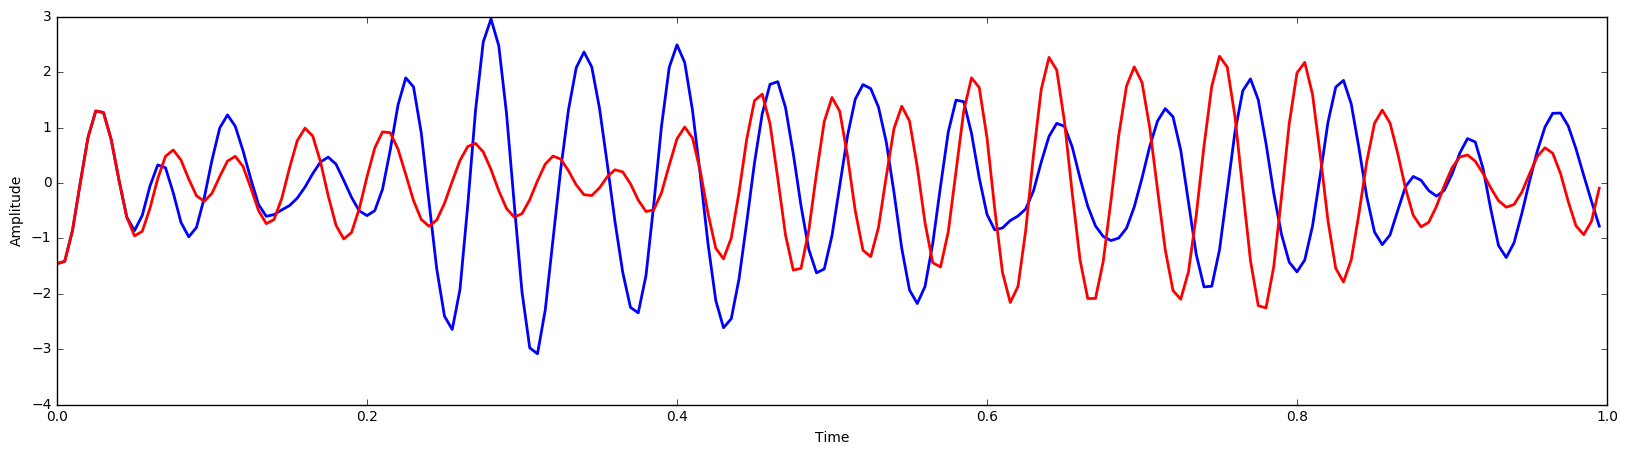

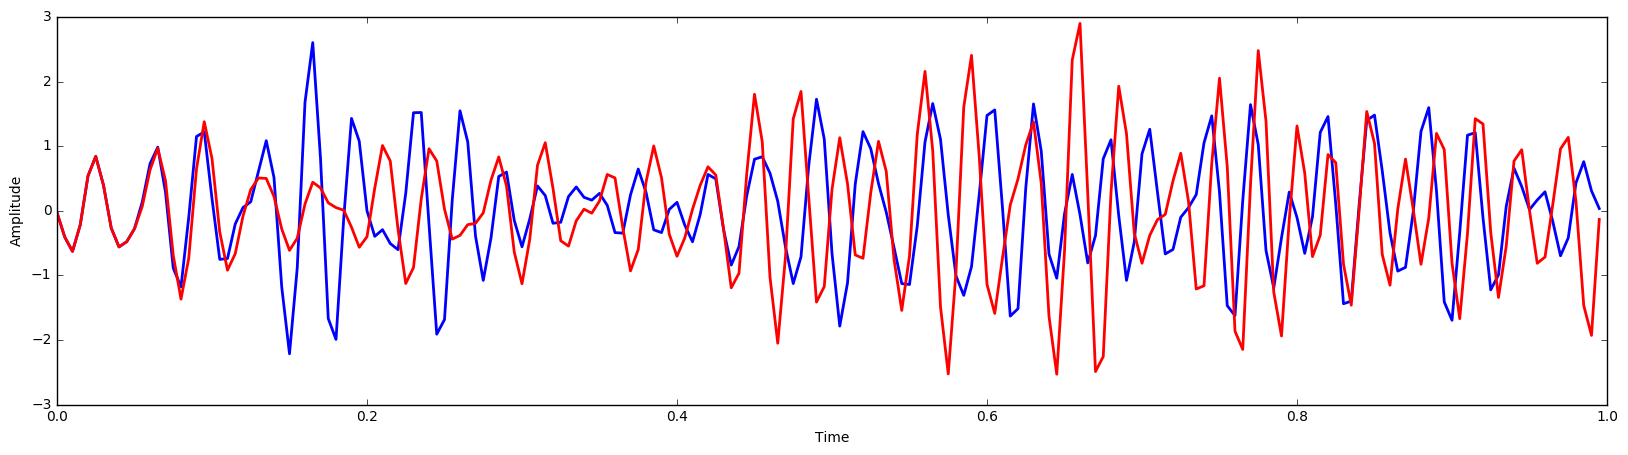

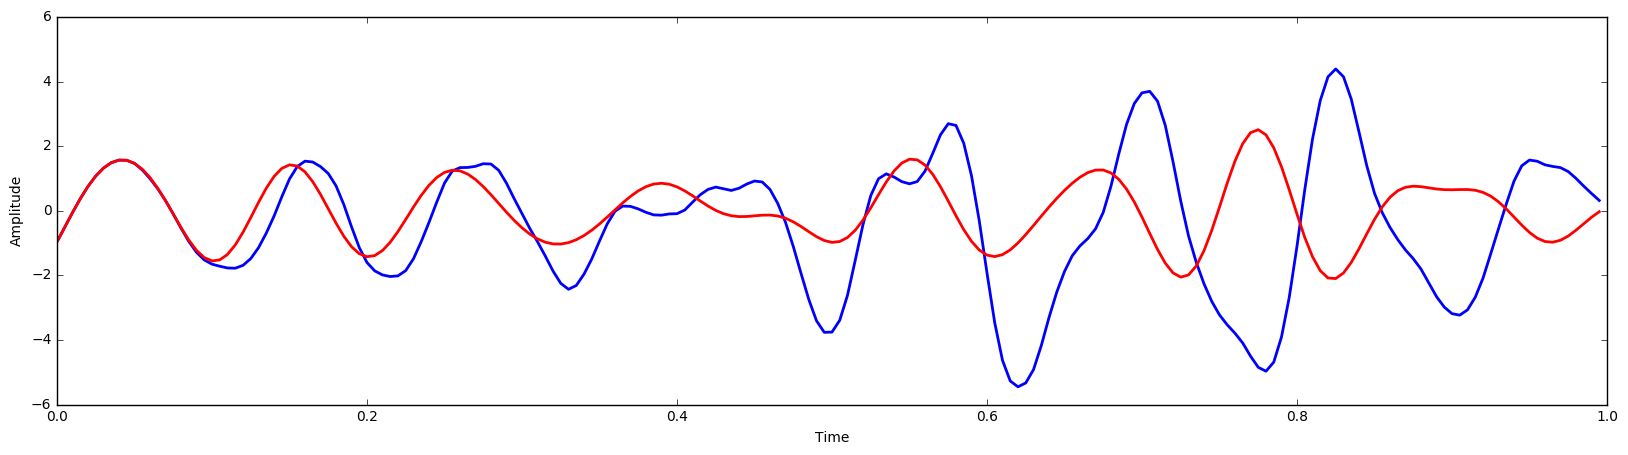

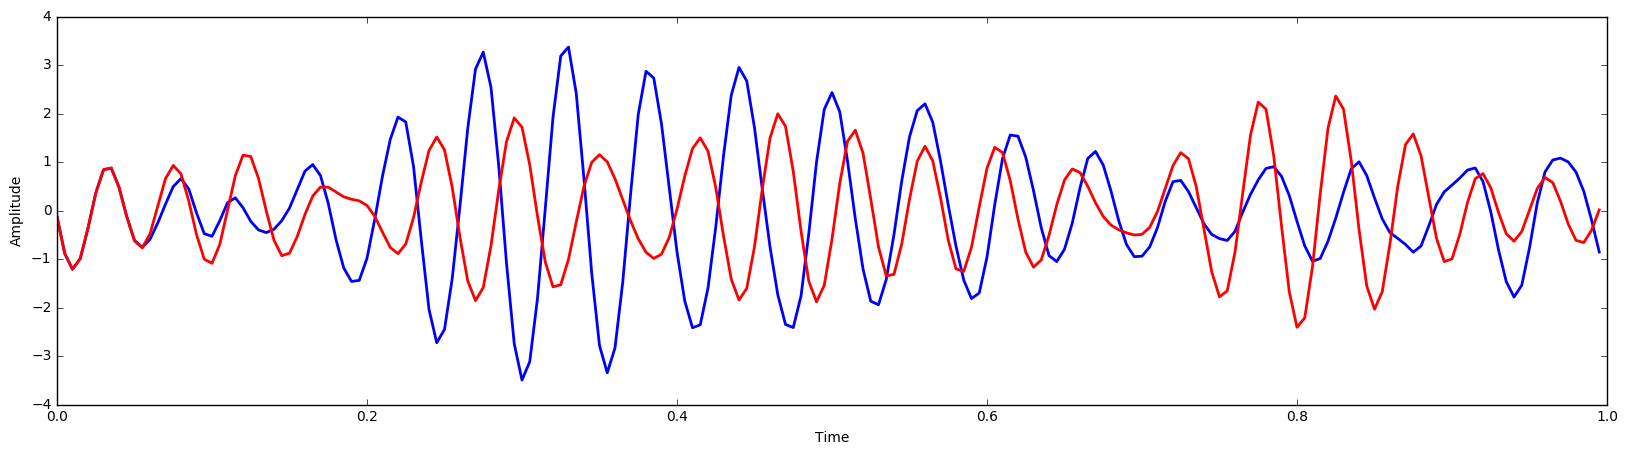

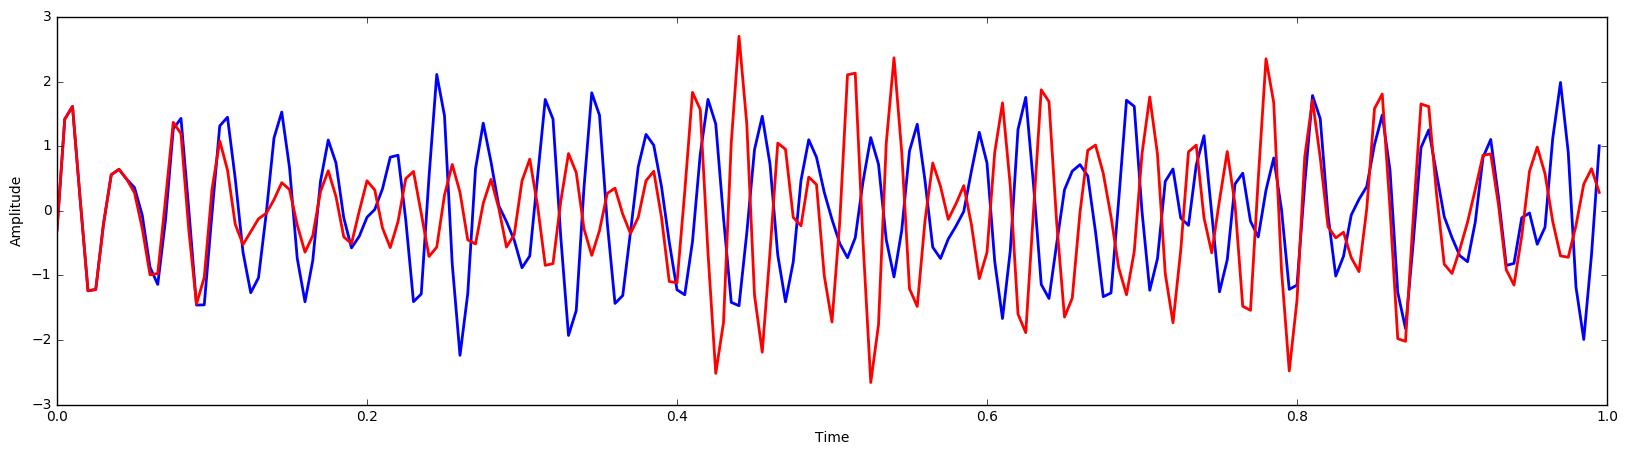

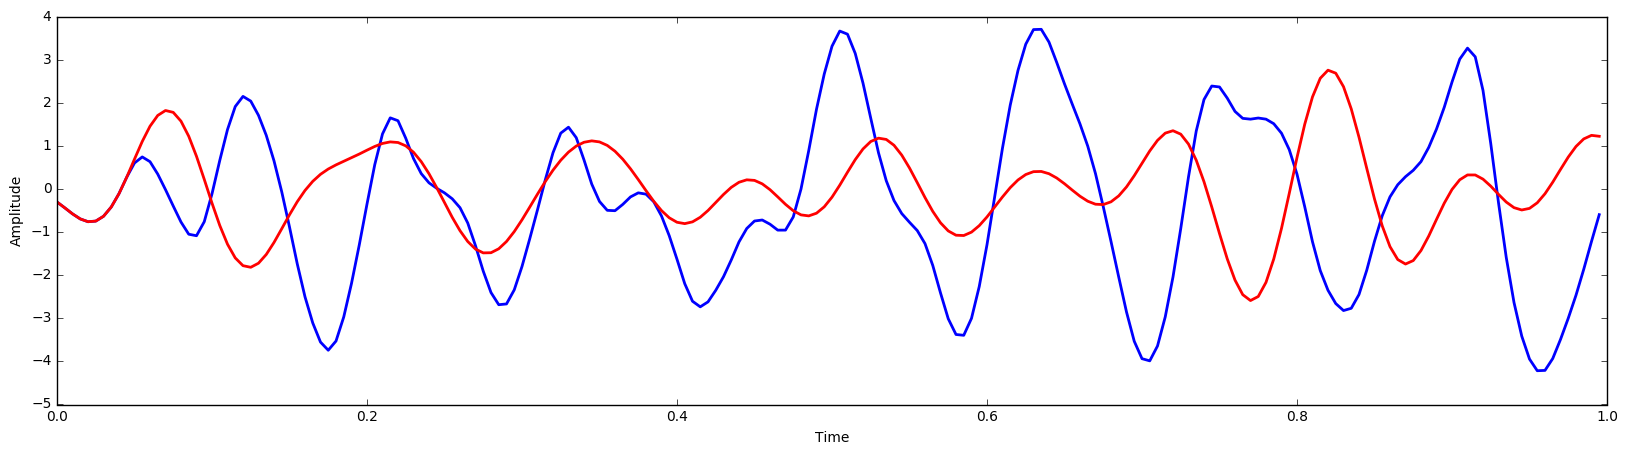

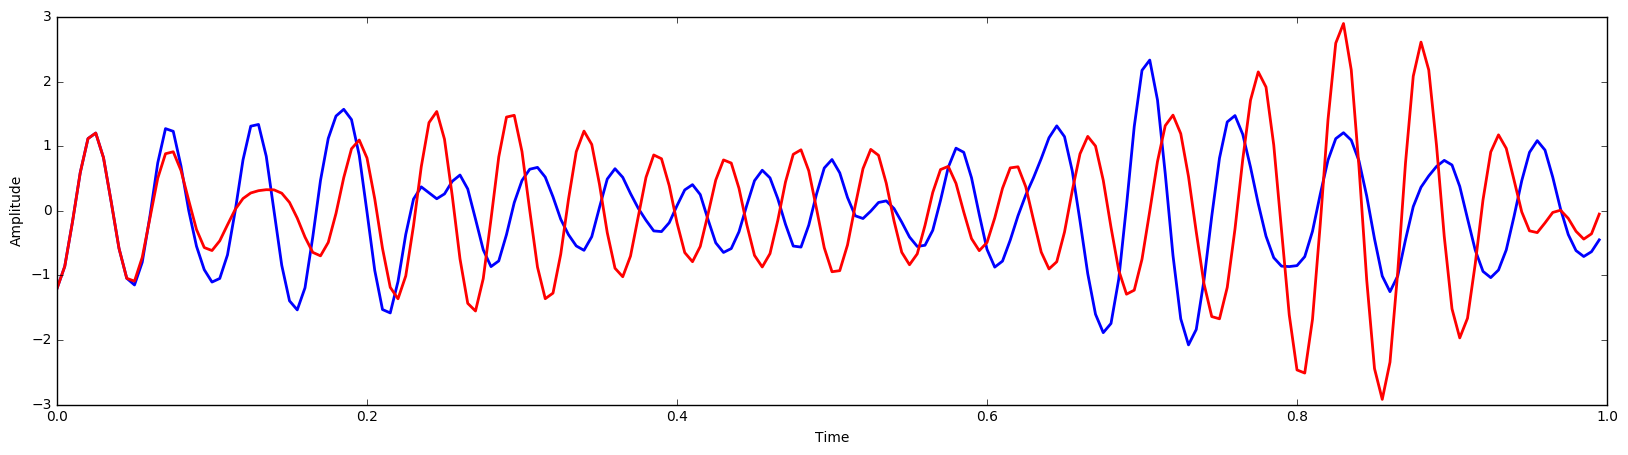

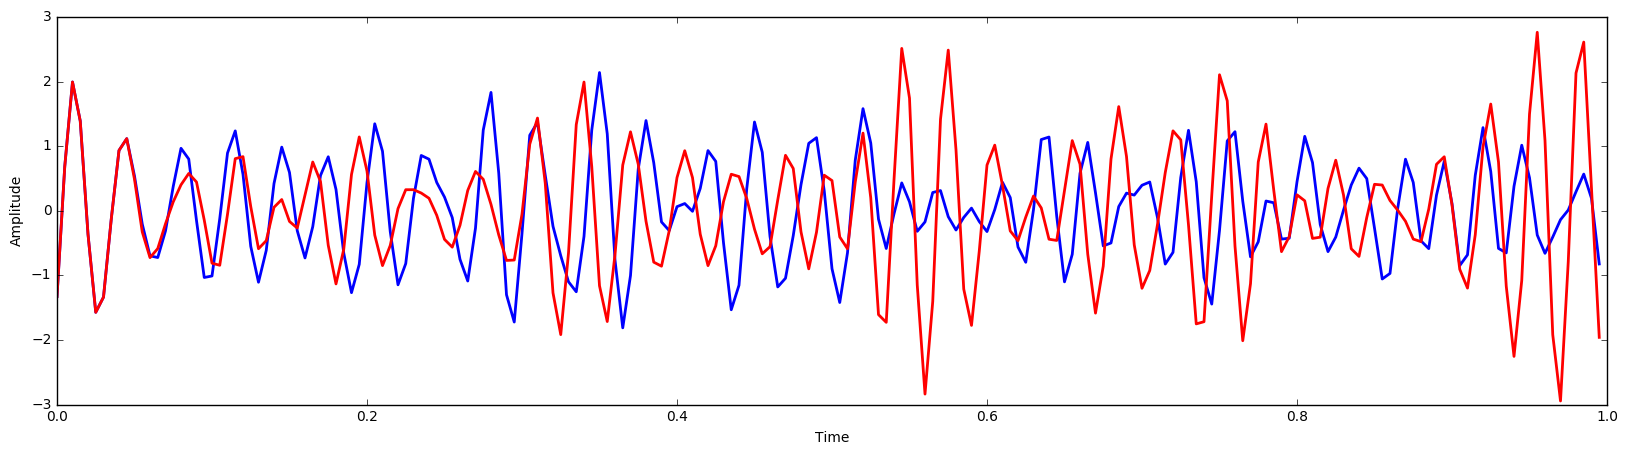

In [11]:
# Plot figures using 4 different start points
for i in range(0, 4):
    num_samples = val_dataset[i,:,:].shape[0]
    realY = val_dataset[i,:,:]
    predictedY = predict(val_dataset[i,:N_HISTORY_SAMPLES,:], num_samples)

    # Plot a channel from the first frequency band
    init_fig()
    plt.plot(x_points, predictedY[:,0], linewidth=2, color='blue');
    plt.plot(x_points, realY[:,0], linewidth=2, color='red');

    # Plot a channel from the second frequency band
    init_fig()
    plt.plot(x_points, predictedY[:,204], linewidth=2, color='blue');
    plt.plot(x_points, realY[:,204], linewidth=2, color='red');

    # Plot a channel from the third frequency band
    init_fig()
    plt.plot(x_points, predictedY[:,408], linewidth=2, color='blue');
    plt.plot(x_points, realY[:,408], linewidth=2, color='red');